In [44]:
import mode_weights_torus
import mode_weights
import numpy as np
import matplotlib.pyplot as plt
import os

# EXAMPLES SECTION

## GOOD SITUATION

In [19]:
def display_graph(solver, X_eval, n_center, centers, sigma_star, X_samples, U, nu, p_star):

    alpha = solver.alpha

    fig,ax = plt.subplots(2,2)
    fig.set_size_inches(12,7)

    estimated_modes = []
    real_modes = []
    for i in range(n_center):
        real_modes.append(g(X_eval - centers[i], sigma_star[i]))
        estimated_modes.append(mode_weights.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
        ax[0][0].plot(X_eval, real_modes[-1], label='nu_'+str(i))
        ax[0][0].plot(X_eval, estimated_modes[-1], label='Estimated nu_'+str(i))

    ax[0][0].set_title('Mode densities estimated')
    ax[0][0].legend()

    y_1 = []
    for i in range(len(solver.p_list)):
        val = solver.surrogate_function(solver.p_list[i])
        y_1.append(val)
    ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='J_n(p)')
    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    y_2=[]
    X_quad = 4 * ((np.arange(800)/800).reshape(-1, 1)*2-1)
    for i in range(len(solver.p_list)):
        y_2.append(solver.objective_function(U, nu, X_quad, solver.p_list[i]))
    ax[0][1].plot(np.arange(len(solver.p_list)), y_2, label='J_\infty(p)')

    y_3 = []
    for i in range(len(solver.p_list)):
        y_3.append(solver.KL(U, X_quad, solver.p_list[i]))
    ax[0][1].plot(np.arange(len(solver.p_list)), y_3, label='I(\pi_n(p))')

    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    for i in range(n_center):
        a = ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
        ax[1][0].axhline(y=p_star[i], linestyle='dashed', label='Target p_'+str(i), color=a[0].get_color())
    ax[1][0].set_title('Weight values along the descent')
    ax[1][0].legend()

    y = solver.evaluate(X_eval, solver.p_list[-1])
    z = solver.evaluate(X_eval, solver.p_list[0])
    ax[1][1].plot(X_eval, y, label='Final estimation')
    ax[1][1].plot(X_eval, z, label='Initial estimation')
    ax[1][1].plot(X_eval, np.exp(-U(X_eval)), label='True distribution')
    ax[1][1].set_title('Estimation vs target')
    ax[1][1].legend()

    plt.tight_layout()
    plt.show()

X_eval = 3 * ((np.arange(400)/400).reshape(-1, 1)*2-1)

In [91]:
# Target definition and data generation

n_center = 2
dim = 1
centers = np.array([np.array([-1]), np.array([1])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = 0.3, 0.3 #np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 6400
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))

# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 0
bw = ['silverman']*n_center

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_quad, solver.p_list[0])))

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 2.43s.
Iteration 0
Iteration 20
Iteration 40
Gradient descent done ; In 48 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.74973657 0.25026343]
Surrogate evaluation at the beginning of the GD: 0.4464929380295668
Real target evaluation at the end of the GD: 0.11335898158663578


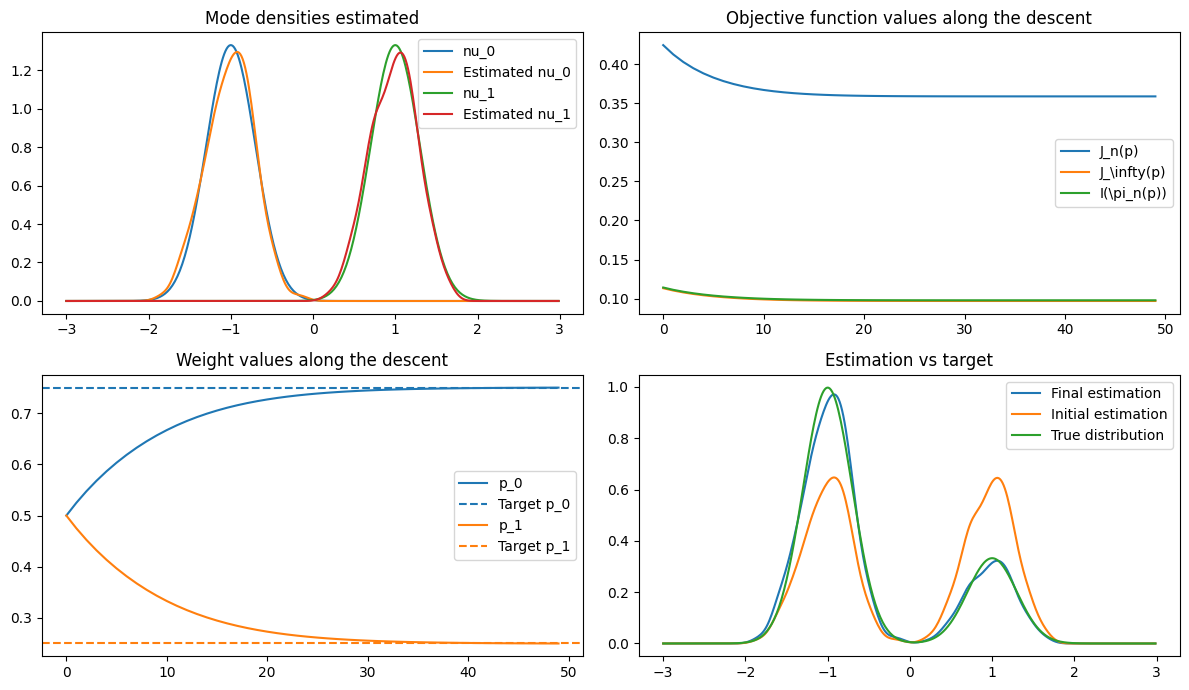

In [73]:
display_graph(solver, X_eval, n_center, centers, sigma_star, X_samples, U, nu, p_star)

### Few datapoints

In [46]:


script_dir = 'C:/Users/rayci/Desktop/Stage_LJLL/Code/cleaner_code' #os.path.dirname(os.path.abspath(__file__))
storage_folder = os.path.join(script_dir, "table_storage")

file_name_output = 'few_datapoints_evolution'

#### Sampling ####

n_dataset = 15
n_tot = 3200
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800, 1600]
n_limitations = len(sample_limitations)
labels = '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0], solver.surrogate_function(p_final), solver.objective_function(U, nu, X_quad, p_final), solver.KL(U, X_quad)]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = os.path.join(storage_folder, file_name_output + ".npy")
np.save(file_path, collection)
file_path = os.path.join(storage_folder, file_name_output + ".txt")
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 64 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 64 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 64 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 200 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done

### Table overlapping modes

In [53]:

sigma_star_list = [[0.3]*2, [0.4]*2, [0.5]*2, [0.6]*2, [0.65]*2, [0.7]*2, [0.75]*2, [0.8]*2]
n_limitations = len(sigma_star_list)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X, sigma):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma[i])
    return -np.log(density_value)

def nu_1(X, sigma):
    return g(X - centers[0], sigma[0])

def nu_2(X, sigma):
    return g(X - centers[1], sigma[1])

nu = [nu_1, nu_2]

script_dir = 'C:/Users/rayci/Desktop/Stage_LJLL/Code/cleaner_code' #os.path.dirname(os.path.abspath(__file__))
storage_folder = os.path.join(script_dir, "table_storage")

file_name_output = 'closer_modes_data'

#### Sampling ####

n_dataset = 15
n_tot = 600
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_dataset.append([])
    U_dataset.append([])
    for k in range(len(sigma_star_list)):
        X_samples, U_samples = [], []
        for i in range(n_center):
            X_samples.append( np.random.normal(0, sigma_star_list[k][i], (n_samples[i],dim)) + centers[i] )
            U_samples.append(U(X_samples[-1], sigma_star_list[k]))
        X_dataset[-1].append(X_samples)
        U_dataset[-1].append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0


labels = '$p_f$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sigma_star_list)):
        ## Data limitation to k ##
        
        sigma_star = sigma_star_list[k]
        print('** Starting batch for '+str(sigma_star)+' standard deviation **')
        X_limited, U_samples_limited = X_dataset[j][k], U_dataset[j][k]

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0]]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = os.path.join(storage_folder, file_name_output + ".npy")
np.save(file_path, collection)
file_path = os.path.join(storage_folder, file_name_output + ".txt")
with open(file_path, "w") as f:
    f.write(repr(sigma_star_list) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for [0.3, 0.3] standard deviation **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 65 iterations, the minimum displacement has been reached.
Took 0.0s.
** Starting batch for [0.4, 0.4] standard deviation **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 64 iterations, the minimum displacement has been reached.
Took 0.0s.
** Starting batch for [0.5, 0.5] standard deviation **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Gradient descent done ; In 54 iterations, the minimum displacement has been reached.
Took 0.0s.
** Starting batch for [0.6, 0.6] standard deviation **
Starting bandwidth computations an

### Overlapping modes varying n

In [67]:
sigma_star = 0.6, 0.6

script_dir = 'C:/Users/rayci/Desktop/Stage_LJLL/Code/cleaner_code' #os.path.dirname(os.path.abspath(__file__))
storage_folder = os.path.join(script_dir, "table_storage")

file_name_output = 'closer_modes_varying_n'

#### Sampling ####

n_dataset = 15
n_tot = 12800
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
n_limitations = len(sample_limitations)
labels = '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0], solver.surrogate_function(p_final), solver.objective_function(U, nu, X_quad, p_final), solver.KL(U, X_quad)]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = os.path.join(storage_folder, file_name_output + ".npy")
np.save(file_path, collection)
file_path = os.path.join(storage_folder, file_name_output + ".txt")
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 67 iterations, the minimum displacement has been reached.
Took 0.0s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 65 iterations, the minimum displacement has been reached.
Took 0.0s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Gradient descent done ; In 69 iterations, the minimum displacement has been reached.
Took 0.0s.
** Starting batch for 200 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. To

### More modes 1D

In [89]:
# Target definition and data generation

n_center = 5
dim = 1
centers = np.array([np.array([-4]), np.array([-2]), np.array([0]), np.array([2]), np.array([4])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = [0.3]*n_center
c_star = np.array([0.12, 0.34, 0.08, 0.22, 0.24])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

nu = []

for i in range(n_center):
    nu.append(lambda X, i=i: g(X - centers[i], sigma_star[i]))


script_dir = 'C:/Users/rayci/Desktop/Stage_LJLL/Code/cleaner_code' #os.path.dirname(os.path.abspath(__file__))
storage_folder = os.path.join(script_dir, "table_storage")

file_name_output = 'more_modes'

#### Sampling ####

n_dataset = 15
n_tot = 4000
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 0.1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800]
n_limitations = len(sample_limitations)
labels = '$p_{0,f}$', '$p_{1,f}$', '$p_{2,f}$', '$p_{3,f}$', '$p_{4,f}$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

n_quad = 1200
X_quad = (4*(2*np.arange(n_quad)/n_quad - 1)).reshape(-1,1) # integrals computed on [-4, 4]

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$', '$J_n(p_f)$', '$J_\\infty(p_f)$', '$I(\\pi_n(p_f))$'
        batch_collection = np.array([p_final[0], p_final[1], p_final[2], p_final[3], p_final[4]])/p_star # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = os.path.join(storage_folder, file_name_output + ".npy")
np.save(file_path, collection)
file_path = os.path.join(storage_folder, file_name_output + ".txt")
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Gradient descent done ; In 90 iterations, the minimum displacement has been reached.
Took 0.03s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.01s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Gradient descent done ; In 92 iterations, the minimum displacement has been reached.
Took 0.04s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.02s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Gradient descent done ; In 93 iterations, the minimum displacement has been reached.
Took 0.03s.
** Starting batch for 200 datapoints **
Starting bandwidth computations and KDE e

### HIGH D LOW SIGMA

In [100]:
# Target definition and data generation

n_center = 2
dim = 10
centers = np.array([np.array([-1] + [0]*(dim-1)), np.array([1] + [0]*(dim-1))]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = 0.3, 0.3 #np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

script_dir = 'C:/Users/rayci/Desktop/Stage_LJLL/Code/cleaner_code' #os.path.dirname(os.path.abspath(__file__))
storage_folder = os.path.join(script_dir, "table_storage")

file_name_output = 'high_d_low_sigma'

#### Sampling ####

n_dataset = 15
n_tot = 12800
sample_repartition = np.ones((n_center))/n_center # equal
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding

X_dataset = []
U_dataset = []
for j in range(n_dataset):
    X_samples, U_samples = [], []
    for i in range(n_center):
        X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
        U_samples.append(U(X_samples[-1]))
    X_dataset.append(X_samples)
    U_dataset.append(U_samples)

#### Gradient descent for various number of data ####

h = 1
max_iter = 200
accuracy = 0.00001
p0 = np.ones((n_center))/n_center
KL_type = 0

sample_limitations = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
n_limitations = len(sample_limitations)
labels = '$p_f$'
n_columns = len(labels)
collection = np.zeros((n_limitations, n_dataset, n_columns))

import numpy as np
from itertools import product

def generate_grid(dim: int, n_quad: int):
    axis_points = np.linspace(-4, 4, n_quad)
    grid = np.array(list(product(axis_points, repeat=dim)))
    return grid

for j in range(n_dataset):
    print('----<#### Dataset '+str(j)+' ####>----')
    for k in range(len(sample_limitations)):
        ## Data limitation to k ##
        
        n_lim = sample_limitations[k]
        print('** Starting batch for '+str(n_lim)+' datapoints **')
        X_limited, U_samples_limited = [], []
        for i in range(n_center):
            X_limited.append(X_dataset[j][i][:n_lim])
            U_samples_limited.append(U_dataset[j][i][:n_lim])

        ## Training ##
        solver = mode_weights.GD_estimator(KL_type, p0, U_samples_limited, X_limited, h, accuracy, max_iter, ['silverman']*n_center)
        solver.optimise()

        alpha = solver.alpha
        p_final = solver.p_list[-1]
        ## Data collection ##
        '$p_f$'
        batch_collection = np.array([p_final[0]]) # solver.objective_function_measure(U, X_quad)
        collection[k][j] = batch_collection

file_path = os.path.join(storage_folder, file_name_output + ".npy")
np.save(file_path, collection)
file_path = os.path.join(storage_folder, file_name_output + ".txt")
with open(file_path, "w") as f:
    f.write(repr(sample_limitations) + "\n")
    f.write(repr(labels))

----<#### Dataset 0 ####>----
** Starting batch for 25 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Gradient descent done ; The maximum number of iterations has been reached.
Took 0.01s.
** Starting batch for 50 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Gradient descent done ; In 151 iterations, the minimum displacement has been reached.
Took 0.01s.
** Starting batch for 100 datapoints **
Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.0s.
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Gradient descent done 

TEST

In [104]:
sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 25600
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))

# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 1
max_iter = 400
eps = 0.0001
KL_type = 0
bw = ['silverman']*n_center

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 20.11s.
Iteration 0
Iteration 20
Gradient descent done ; In 33 iterations, the minimum displacement has been reached.
Took 0.0s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.7466221 0.2533779]


In [107]:
def display_graph_high_d(solver, X_eval, n_center, centers, sigma_star, X_samples, U, nu, p_star):

    alpha = solver.alpha

    fig,ax = plt.subplots(2,2)
    fig.set_size_inches(12,7)

    estimated_modes = []
    real_modes = []
    for i in range(n_center):
        real_modes.append(g(X_eval - centers[i], sigma_star[i]))
        estimated_modes.append(mode_weights.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
        ax[0][0].plot(X_eval[:,0], real_modes[-1], label='nu_'+str(i))
        ax[0][0].plot(X_eval[:,0], estimated_modes[-1], label='Estimated nu_'+str(i))

    ax[0][0].set_title('Mode densities estimated')
    ax[0][0].legend()

    y_1 = []
    for i in range(len(solver.p_list)):
        val = solver.surrogate_function(solver.p_list[i])
        y_1.append(val)
    ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='J_n(p)')
    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    ax[0][1].set_title('Objective function values along the descent')
    ax[0][1].legend()

    for i in range(n_center):
        a = ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
        ax[1][0].axhline(y=p_star[i], linestyle='dashed', label='Target p_'+str(i), color=a[0].get_color())
    ax[1][0].set_title('Weight values along the descent')
    ax[1][0].legend()

    y = solver.evaluate(X_eval, solver.p_list[-1])
    z = solver.evaluate(X_eval, solver.p_list[0])
    ax[1][1].plot(X_eval[:,0], y, label='Final estimation')
    ax[1][1].plot(X_eval[:,0], z, label='Initial estimation')
    ax[1][1].plot(X_eval[:,0], np.exp(-U(X_eval)), label='True distribution')
    ax[1][1].set_title('Estimation vs target')
    ax[1][1].legend()

    plt.tight_layout()
    plt.show()

X_eval_bis = np.concatenate([3 * ((np.arange(400)/400)*2-1).reshape(-1,1), np.zeros((400, dim-1))], axis=1)

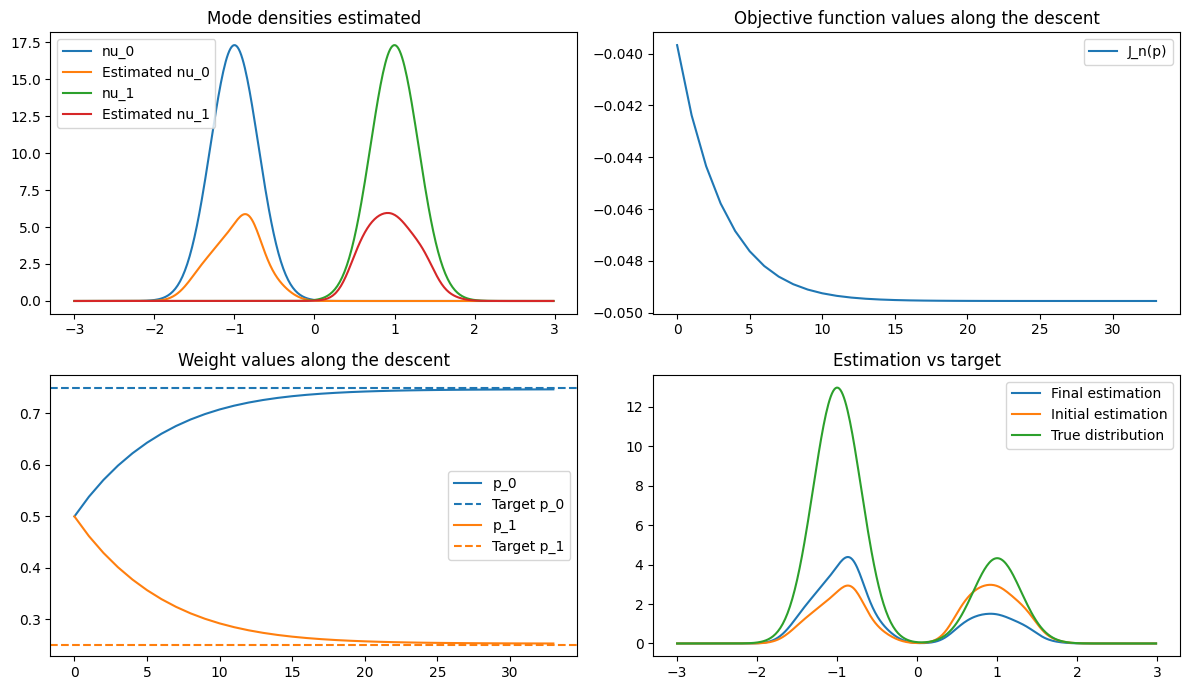

In [106]:
display_graph_high_d(solver, X_eval_bis, n_center, centers, sigma_star, X_samples, U, nu, p_star)

Delimiter

In [51]:
sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 50
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))

# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 0
bw = ['silverman']*n_center

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
#print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
#print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_quad)))

TypeError: U() missing 1 required positional argument: 'sigma'

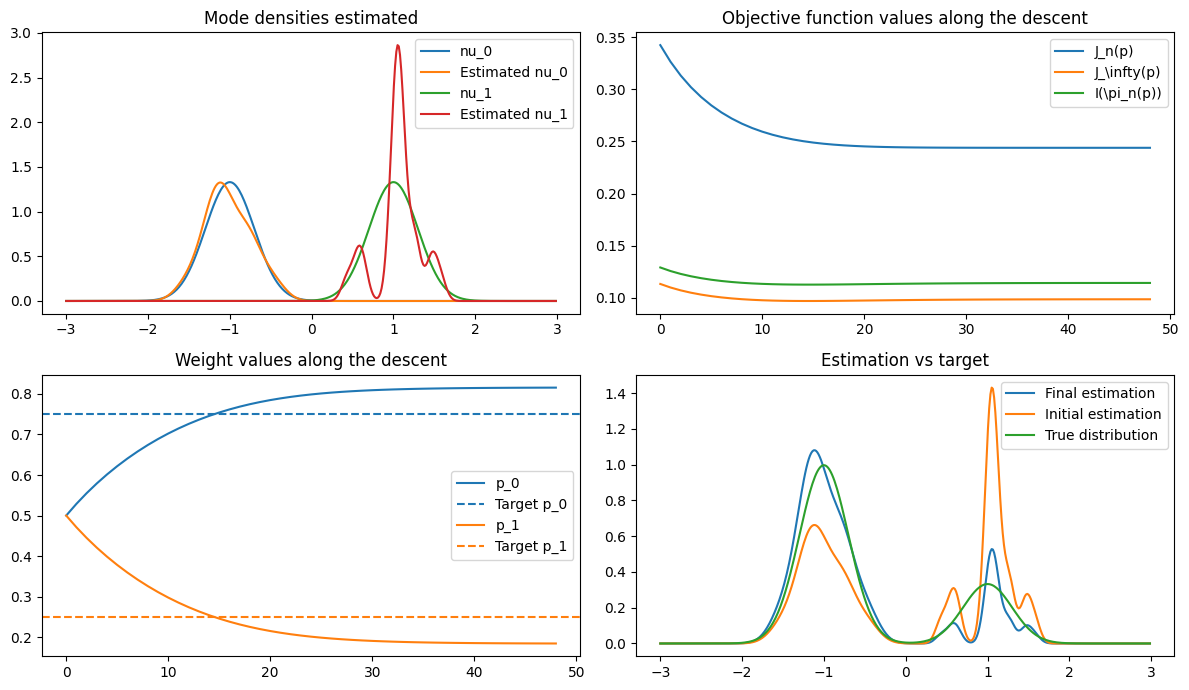

In [39]:
display_graph(solver, X_eval, n_center, centers, sigma_star, X_samples, U, nu, p_star)

## Torus tests

In [5]:
# Target preparation:

n_center = 2
dim = 1
sigma_min, sigma_max = 0.08, 0.08
centers = np.array([np.array([0.25]), np.array([0.75])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * mode_weights_torus.compute_gaussian_density(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return mode_weights_torus.compute_gaussian_density(X - centers[0], sigma_star[0])

def nu_2(X):
    return mode_weights_torus.compute_gaussian_density(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.array([1/3, 2/3]) # equal
n_tot = 800
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    raw_samples = np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i]
    X_samples.append(np.mod(raw_samples, np.ones((n_samples[i],dim)) ))
    U_samples.append(U(X_samples[-1]))


In [6]:
# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 1
bw = ['silverman']*n_center

solver = mode_weights_torus.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
#print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
#print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_quad)))


Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.34s.
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Gradient descent done ; In 46 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.75685011 0.24314989]


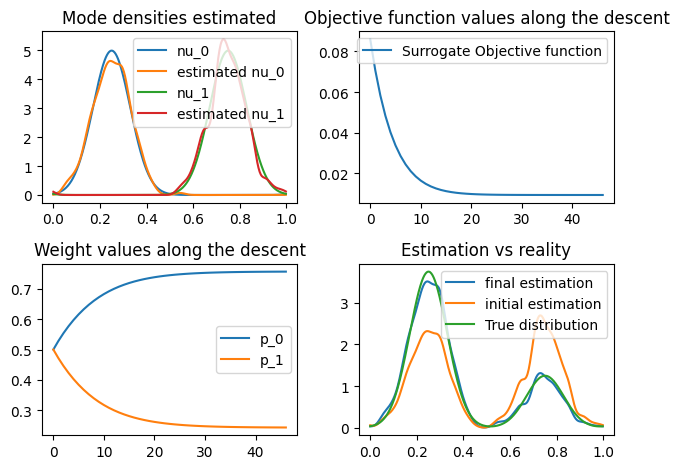

In [7]:
#########################################################################################################################

# Graph display

alpha = solver.alpha

fig,ax = plt.subplots(2,2)

X_eval = (np.arange(400)/400).reshape(-1, 1)
estimated_modes = []
real_modes = []
for i in range(n_center):
    real_modes.append(nu[i](X_eval))
    estimated_modes.append(mode_weights_torus.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
    ax[0][0].plot(X_eval, real_modes[-1], label='nu_'+str(i))
    ax[0][0].plot(X_eval, estimated_modes[-1], label='estimated nu_'+str(i))

ax[0][0].set_title('Mode densities estimated')
ax[0][0].legend()

y_1 = []
for i in range(len(solver.p_list)):
    val = solver.surrogate_function(solver.p_list[i])
    y_1.append(val)
ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='Surrogate Objective function')
ax[0][1].set_title('Objective function values along the descent')
ax[0][1].legend()

#y_2=[]
#for i in range( M ):
#    y_2.append(KL_wrt_mu(solver, U, solver.p_list[i%len(solver.p_list)], solver.sigma_list[i%len(solver.sigma_list)]))
#ax[2][1].plot(np.arange(M), y_2, label='Ideal objective function')
#ax[2][1].set_title('Objective function values along the descent')
#ax[2][1].legend()

for i in range(n_center):
    ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
ax[1][0].set_title('Weight values along the descent')
ax[1][0].legend()

y = solver.evaluate(X_eval, solver.p_list[-1])
z = solver.evaluate(X_eval, solver.p_list[0])
ax[1][1].plot(X_eval, y, label='final estimation')
ax[1][1].plot(X_eval, z, label='initial estimation')
ax[1][1].plot(X_eval, np.exp(-U(X_eval)), label='True distribution')
ax[1][1].set_title('Estimation vs reality')
ax[1][1].legend()

plt.tight_layout()
plt.show()

## Tests in high dimension on the whole space

In [ ]:
# Target preparation:

def place_1D_points_on_first_axis(points, d):
    return np.concatenate([points.reshape(-1,1), np.zeros((len(points), d-1))], axis=1)

dim = 2
n_center = 2
centers_loc_first_axis = np.array([np.array([-1]), np.array([1])])
centers = place_1D_points_on_first_axis(centers_loc_first_axis, dim)
sigma_star = 0.3, 0.3
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 2400
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))
    

In [22]:
# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 1
bw = ['silverman']*n_center

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
#print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
#print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_quad)))

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.25s.
Iteration 0
Iteration 20
Iteration 40
Gradient descent done ; In 47 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.75018213 0.24981787]


NameError: name 'place_1D_points_on_first_axis' is not defined

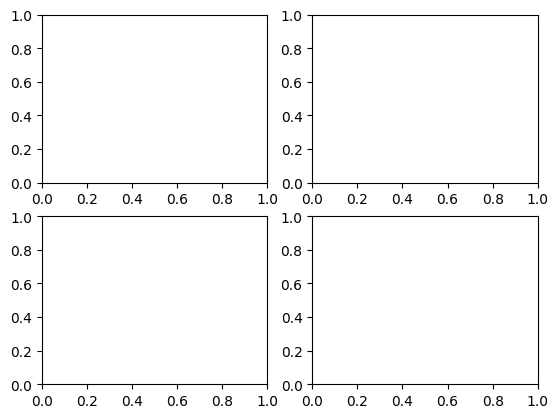

In [25]:

alpha = solver.alpha

fig,ax = plt.subplots(2,2)

X_eval = place_1D_points_on_first_axis((6 * ((np.arange(400)/400)-0.5)).reshape(-1,1), dim)
estimated_modes = []
real_modes = []
for i in range(n_center):
    real_modes.append(g(X_eval - centers[i], sigma_star[i]))
    estimated_modes.append(mode_weights.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
    ax[0][0].plot(X_eval[:,0], real_modes[-1], label='nu_'+str(i))
    ax[0][0].plot(X_eval[:,0], estimated_modes[-1], label='estimated nu_'+str(i))

ax[0][0].set_title('Mode densities estimated')
ax[0][0].legend()

y_1 = []
for i in range(len(solver.p_list)):
    val = solver.surrogate_function(solver.p_list[i])
    y_1.append(val)
ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='Surrogate Objective function')
ax[0][1].set_title('Objective function values along the descent')
ax[0][1].legend()

#y_2=[]
#for i in range( M ):
#    y_2.append(KL_wrt_mu(solver, U, solver.p_list[i%len(solver.p_list)], solver.sigma_list[i%len(solver.sigma_list)]))
#ax[2][1].plot(np.arange(M), y_2, label='Ideal objective function')
#ax[2][1].set_title('Objective function values along the descent')
#ax[2][1].legend()

for i in range(n_center):
    ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
ax[1][0].set_title('Weight values along the descent')
ax[1][0].legend()

y = solver.evaluate(X_eval, solver.p_list[-1])
z = solver.evaluate(X_eval, solver.p_list[0])
ax[1][1].plot(X_eval[:,0], y, label='final estimation')
ax[1][1].plot(X_eval[:,0], z, label='initial estimation')
ax[1][1].plot(X_eval[:,0], np.exp(-U(X_eval)), label='True distribution')
ax[1][1].set_title('Estimation vs target')
ax[1][1].legend()

plt.tight_layout()
plt.show()